<a href="https://colab.research.google.com/github/Gabriellemga/Python_Data_Science_Alura/blob/main/Rgressao_series_temporais_com_statsmodels/Projeto_Fazendas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regressão: realizando previsão de séries temporais com statsmodels
-----



In [1]:
dados_f1 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F1.csv'
dados_f2 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F2.csv'
dados_f3 = 'https://raw.githubusercontent.com/Mirlaa/s-ries-temporais-statsmodels/main/Dados/Temperatura_mensal_F3.csv'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Fazenda 1

![Alt text: Imagem de uma fazenda com plantações de uvas](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%201.png?raw=true)

In [3]:
df_f1 = pd.read_csv(dados_f1)
df_f1

,DATA,TEMP
0,1963-05-01,23.11
1,1963-06-01,24.20
2,1963-07-01,25.37
3,1963-08-01,23.86
4,1963-09-01,23.03
...,...,...
727,2023-12-01,19.49
728,2024-01-01,19.28
729,2024-02-01,19.73
730,2024-03-01,20.44


In [4]:
df_f1['DATA'] = pd.to_datetime(df_f1['DATA'], format='%Y-%m-%d')
df_f1.set_index(['DATA'], inplace=True, drop=True)

<Axes: xlabel='DATA'>

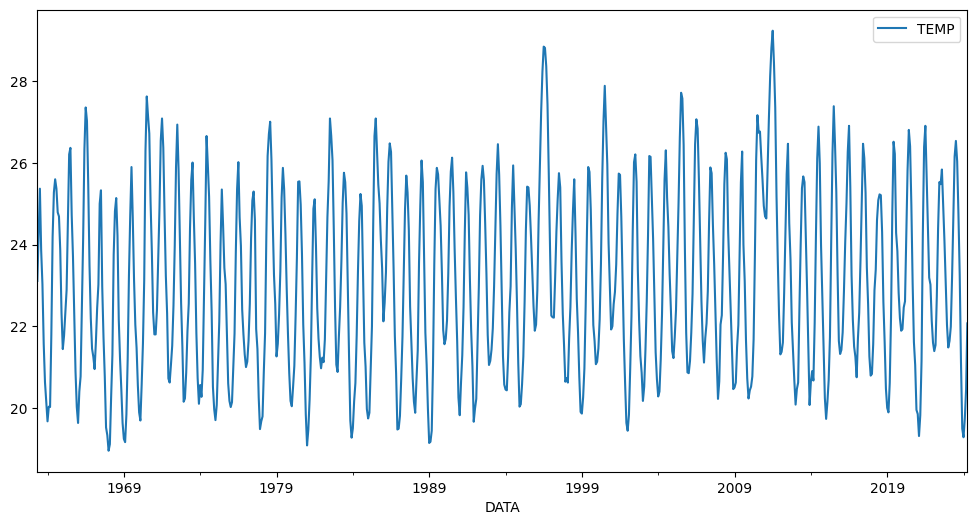

In [5]:
df_f1.plot(figsize=(12, 6))

## Modelo ingênuo

Um modelo ingênuo (naive) em séries temporais é um dos métodos de previsão mais simples, baseando-se na suposição de que o melhor preditor para qualquer ponto futuro é o valor mais recente disponível na série. Isso significa que a previsão para todos os pontos futuros será igual ao último valor observado.

In [6]:
df_f1.shift(1)

,TEMP
DATA,
1963-05-01,NaN
1963-06-01,23.11
1963-07-01,24.20
1963-08-01,25.37
1963-09-01,23.86
...,...
2023-12-01,21.11
2024-01-01,19.49
2024-02-01,19.28


## Avaliando a estacionariedade

In [7]:
from statsmodels.tsa.stattools import adfuller, kpss

def estac(df):
  adf = adfuller(df)
  print(f'Valor-p do Teste estatistico ADF :{adf[1]:.4f}')
  if adf[1] > 0.05:
    print('Não rejeitar a hipótese nula. A série não é estacionária\n')
  else:
    print('Rejeitar a hipótese nula. A série é estacionária\n')

  kpss_saida = kpss(df)
  print(f'Valor-p do Teste estatistico KPSS :{kpss_saida[1]:.4f}')
  if kpss_saida[1] > 0.05:
    print('Não rejeitar a hipótese nula. A série é estacionária')
  else:
    print('Rejeitar a hipótese nula. A série não é estacionária')

In [8]:
estac(df_f1)

Valor-p do Teste estatistico ADF :0.0000
Rejeitar a hipótese nula. A série é estacionária

Valor-p do Teste estatistico KPSS :0.0798
Não rejeitar a hipótese nula. A série é estacionária


In [9]:
divisao = int(len(df_f1) * 0.7)

treino = df_f1.iloc[:divisao].asfreq('MS')
teste = df_f1.iloc[divisao:].asfreq('MS')

## Modelo Autoregressivo (AR)

Um modelo Autorregressivo (AR) é um tipo de modelo de previsão para séries temporais que utiliza uma combinação linear de valores passados da própria série para fazer previsões futuras. Ele se baseia na ideia de que observações passadas podem ser usadas para prever observações futuras de maneira estatisticamente significativa, especialmente quando a série exibe correlação ao longo do tempo.

A equação básica de um modelo autorregressivo de ordem $(p)$ (lag de $p$ períodos) é dada por:

$X_t = c + \beta_1 X_{t-1} + \beta_2 X_{t-2} + \dots + \beta_p X_{t-p} + \epsilon_t$

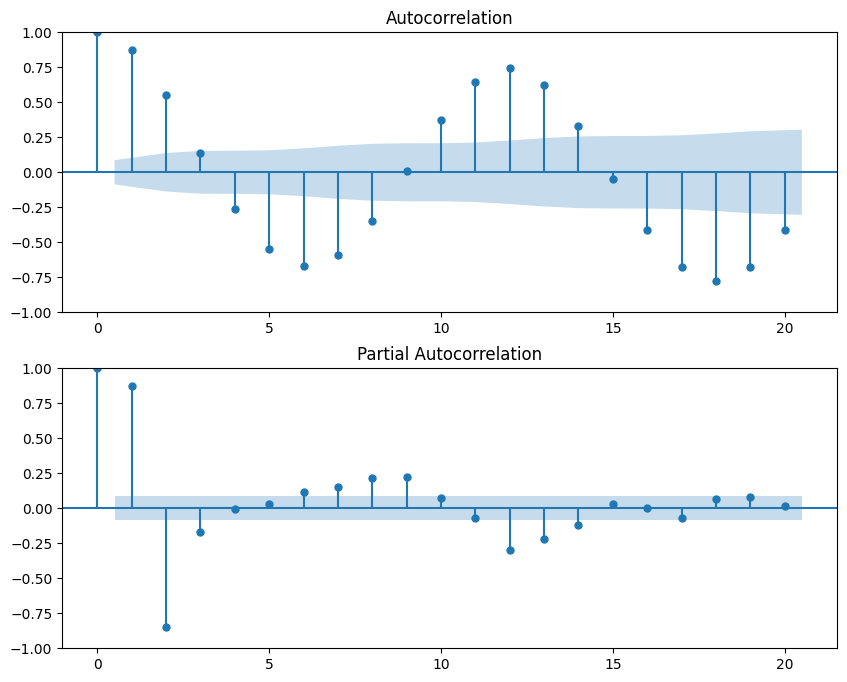

In [10]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)

ax1 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax1)

In [11]:
from statsmodels.tsa.ar_model import AutoReg

ar_mode = AutoReg(treino, 14, old_names=False)
ar_res = ar_mode.fit()
print(ar_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(14)   Log Likelihood                -317.490
Method:               Conditional MLE   S.D. of innovations              0.458
Date:                Wed, 17 Sep 2025   AIC                            666.981
Time:                        22:26:24   BIC                            734.350
Sample:                    07-01-1964   HQIC                           693.421
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0973      0.649      7.855      0.000       3.825       6.369
TEMP.L1        1.1971      0.044     27.078      0.000       1.110       1.284
TEMP.L2       -0.3092      0.069     -4.470      0.0

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/ar_model.py:1138: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ar_params[lag] = -params[i]


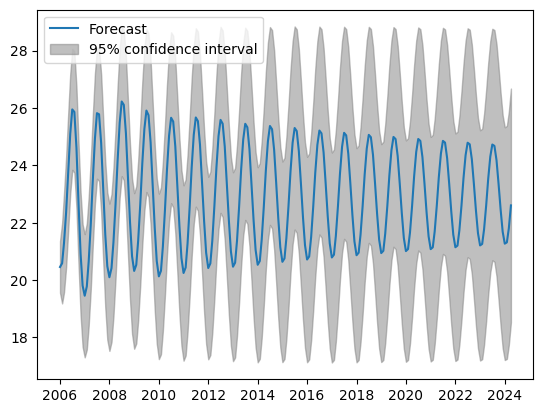

In [12]:
from statsmodels.tsa.ar_model import AutoRegResults

mod_result = AutoRegResults(ar_mode, ar_res.params, ar_res.cov_params())

fig = mod_result.plot_predict(len(treino), len(treino) + len(teste)-1,  )

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def plot_prev(treino, teste, mod, nome_mod = ''):

  previsoes = mod.predict(len(treino), len(treino) + len(teste)-1, dynamic=False)

  plt.figure(figsize=(12, 5))

  plt.plot(teste.index, teste, label='Esperado')
  plt.plot(previsoes.index, previsoes, label='Previsto', color='red')

  plt.title(f'Previsão modelo {nome_mod}')
  plt.ylabel('Temperatura')
  plt.legend()
  plt.show()

  print('\nMétricas:\n')
  mae = mean_absolute_error(teste, previsoes)
  print(f'MAE: {mae}')

  mse = mean_squared_error(teste, previsoes)
  print(f'MSE: {mse}')

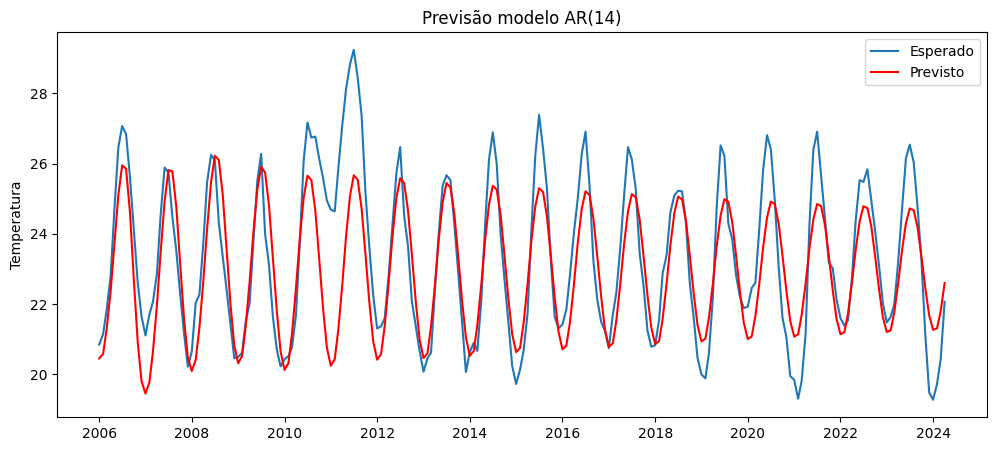


Métricas:

MAE: 1.042706398397448
MSE: 1.8489038142175698


In [14]:
plot_prev(treino, teste, ar_res, 'AR(14)')

### Busca de parâmetros

In [15]:
from statsmodels.tsa.ar_model import ar_select_order

ar_selecao = ar_select_order(treino, 35, old_names = False, ic = 'aic')

In [16]:
ar_selecao.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34]

In [17]:
ar_sel_res = ar_selecao.model.fit()
print(ar_sel_res.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  512
Model:                    AutoReg(34)   Log Likelihood                -265.842
Method:               Conditional MLE   S.D. of innovations              0.422
Date:                Wed, 17 Sep 2025   AIC                            603.684
Time:                        22:26:26   BIC                            753.790
Sample:                    03-01-1966   HQIC                           662.698
                         - 12-01-2005                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.4648      1.091      4.092      0.000       2.326       6.603
TEMP.L1        1.1355      0.045     25.067      0.000       1.047       1.224
TEMP.L2       -0.2017      0.068     -2.958      0.0

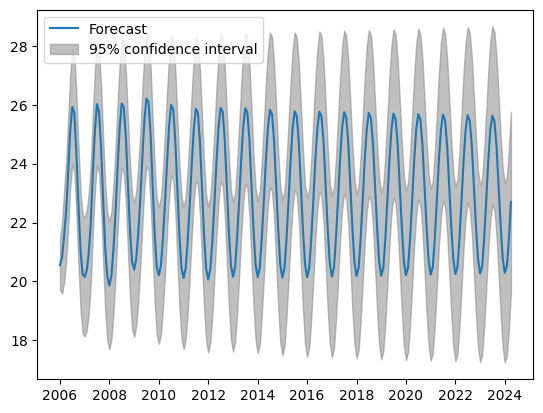

In [18]:
fig = ar_sel_res.plot_predict(len(treino), len(treino) + len(teste) - 1)

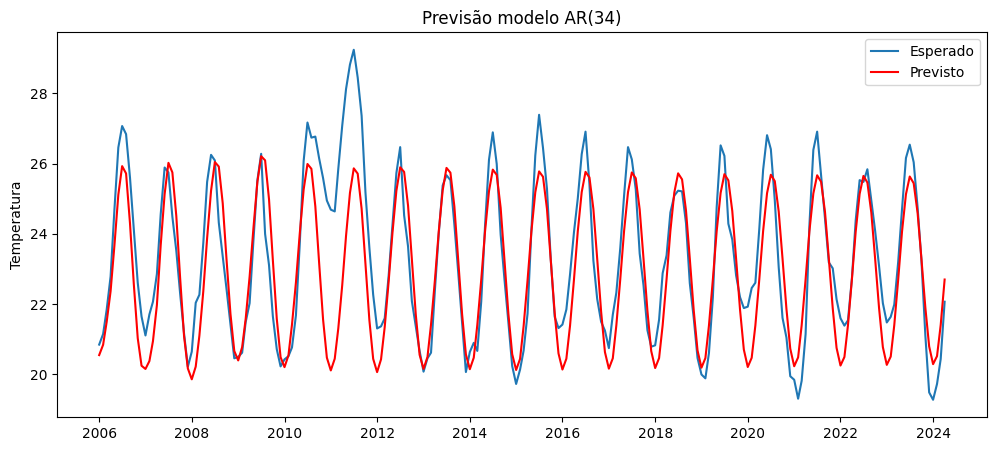


Métricas:

MAE: 0.9474776896244625
MSE: 1.6610673113348695


In [19]:
plot_prev(treino,teste,ar_sel_res,'AR(34)')

# Fazenda 2

![Alt text: Imagem de uma fazenda com plantações de tomates](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%202.png?raw=true)

In [20]:
df_f2 =pd.read_csv(dados_f2)
df_f2

,DATA,TEMP
0,1966-02-01,23.436171
1,1966-03-01,29.787675
2,1966-04-01,25.626345
3,1966-05-01,22.958315
4,1966-06-01,19.513770
...,...,...
694,2023-12-01,15.033869
695,2024-01-01,17.323596
696,2024-02-01,22.818941
697,2024-03-01,29.429283


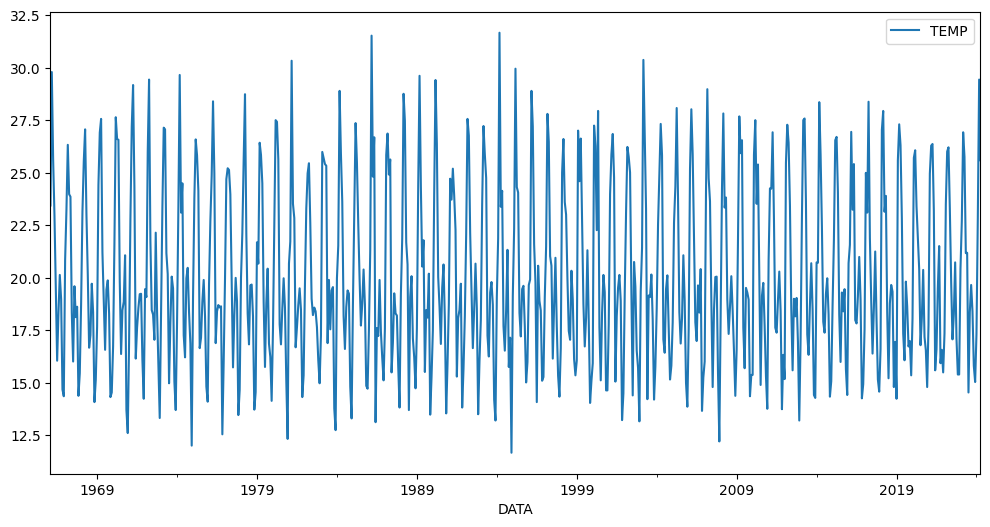

In [21]:
df_f2['DATA'] = pd.to_datetime(df_f2['DATA'], format='%Y-%m-%d')
df_f2.set_index(['DATA'], inplace=True, drop=True)
fig = df_f2.plot(figsize=(12, 6))

In [22]:
estac(df_f2)

Valor-p do Teste estatistico ADF :0.0000
Rejeitar a hipótese nula. A série é estacionária

Valor-p do Teste estatistico KPSS :0.1000
Não rejeitar a hipótese nula. A série é estacionária


/tmp/ipython-input-3783117982.py:11: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_saida = kpss(df)


In [23]:
divisao = int(len(df_f2) * 0.8)

treino = df_f2.iloc[:divisao].asfreq('MS')
teste = df_f2.iloc[divisao:].asfreq('MS')

## Construindo um modelo previsivo

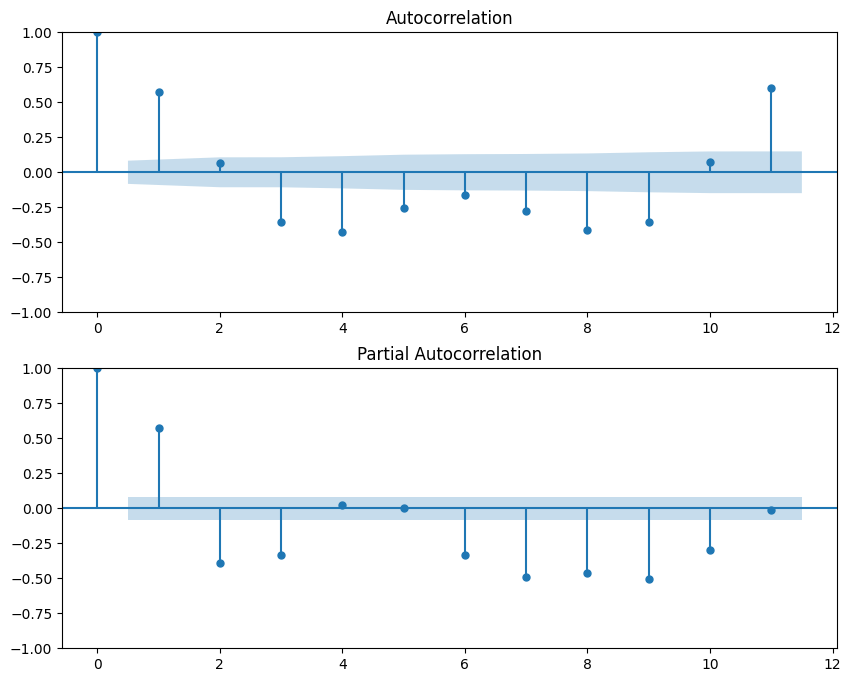

In [24]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=11, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=11, ax=ax2)

In [25]:
ar_mod_f2 = AutoReg(treino, 10, old_names=False).fit()
print(ar_mod_f2.summary())

                            AutoReg Model Results                             
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                    AutoReg(10)   Log Likelihood                -993.284
Method:               Conditional MLE   S.D. of innovations              1.477
Date:                Wed, 17 Sep 2025   AIC                           2010.569
Time:                        22:26:29   BIC                           2062.266
Sample:                    12-01-1966   HQIC                          2030.773
                         - 08-01-2012                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        111.9748      3.244     34.518      0.000     105.617     118.333
TEMP.L1       -0.3349      0.037     -9.170      0.000      -0.406      -0.263
TEMP.L2       -0.3242      0.030    -10.926      0.0

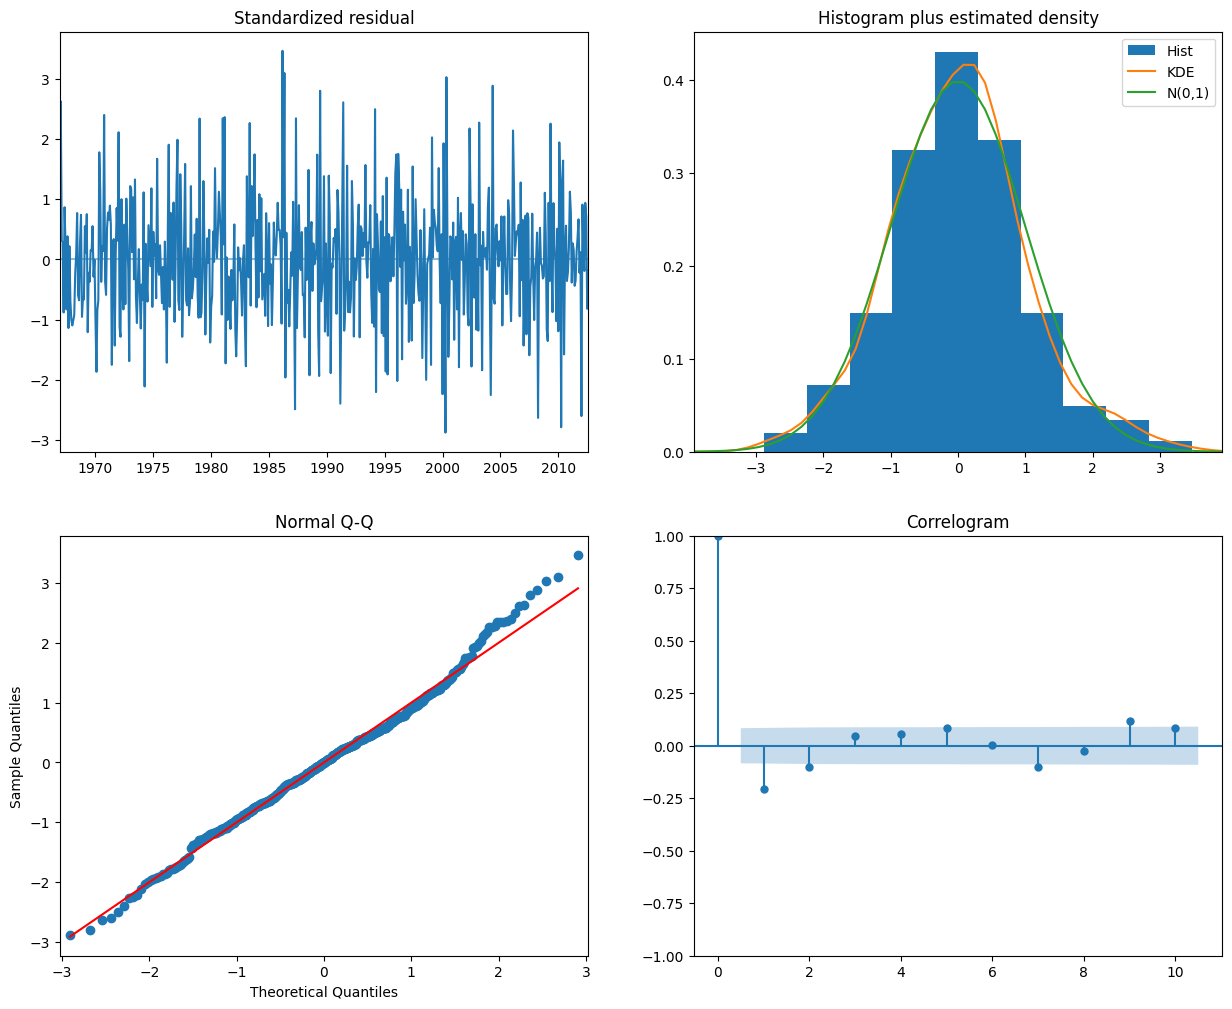

In [26]:
ar_mod_f2.plot_diagnostics(figsize=(15, 12))
plt.show()

### Modelo Autorregressivo de Médias Móveis (ARMA)

O modelo ARMA é uma ferramenta estatística avançada usada na análise de séries temporais que combina duas características principais: autoregressiva (AR) e média móvel (MA).

O modelo ARMA é expresso pela seguinte equação:

$X_t = c + \epsilon_t + \sum_{i=1}^p \beta_i X_{t-i} + \sum_{j=1}^q \theta_j \epsilon_{t-j}$

In [27]:
from statsmodels.tsa.arima.model import ARIMA

arma_mod = ARIMA(treino, order = (10,0,1)).fit()
print(arma_mod.summary())

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(10, 0, 1)   Log Likelihood                -988.510
Date:                Wed, 17 Sep 2025   AIC                           2003.019
Time:                        22:26:45   BIC                           2059.259
Sample:                    02-01-1966   HQIC                          2024.981
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9727      0.008   2365.414      0.000      19.956      19.989
ar.L1         -0.0891      0.058     -1.543      0.123      -0.202       0.024
ar.L2         -0.3211      0.034     -9.505      0.0

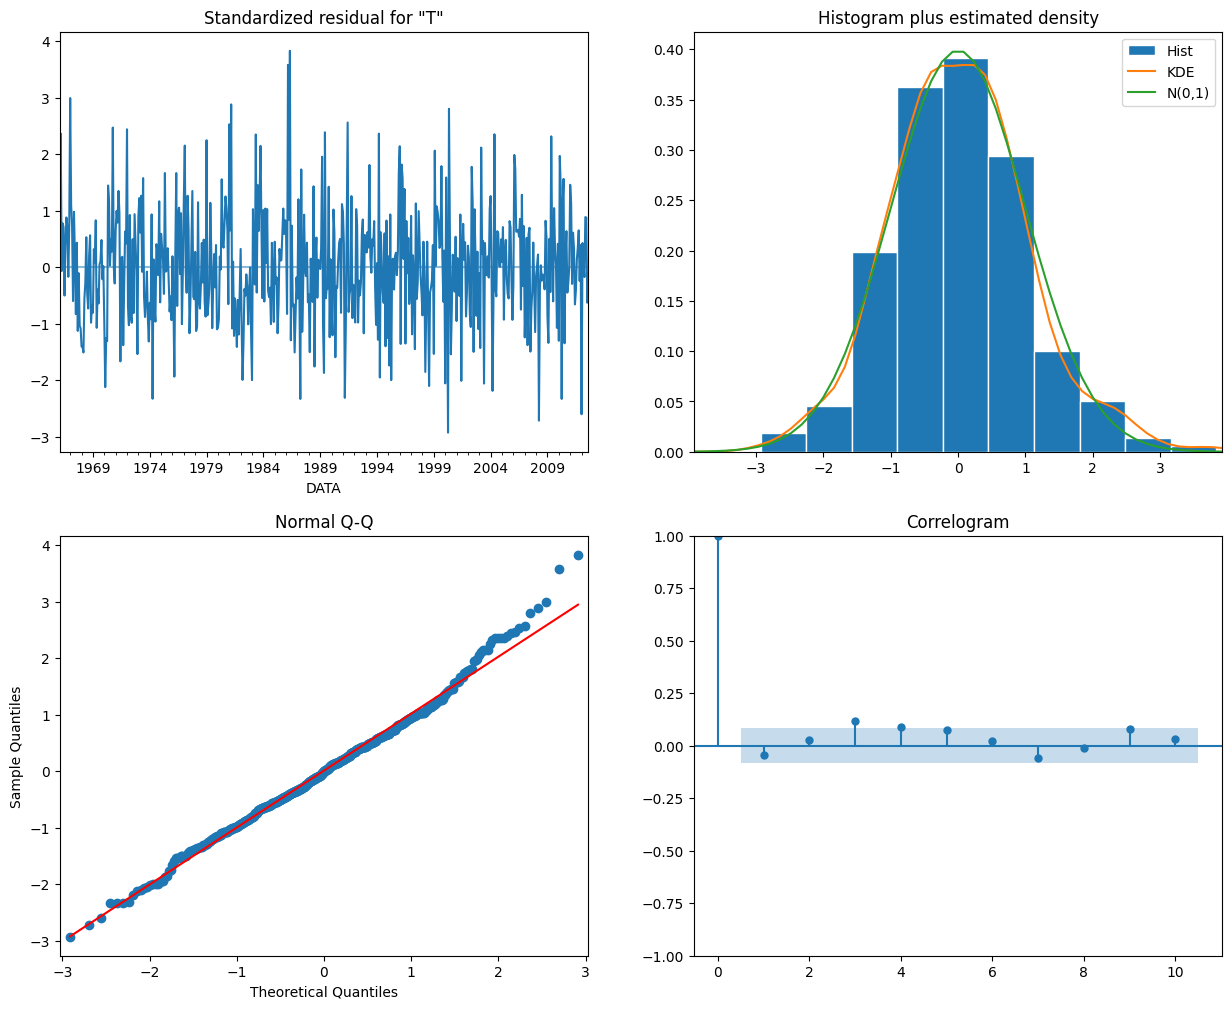

In [28]:
arma_mod.plot_diagnostics(figsize=(15, 12))
plt.show()

### Busca de parâmetros

In [29]:
import itertools
import warnings
warnings.filterwarnings('ignore')


def grid_arima(p_inicial, p_final, q_inicial, q_final, d_valores, treino):
  # Definindo os parâmetros
  p_params = range(p_inicial, p_final)
  q_params = range(q_inicial, q_final)
  d_params = [d_valores]

  # Gerando todas as combinações possíveis usando product
  combinacoes = list(itertools.product(p_params, d_params, q_params))

  aic_grid = dict()
  # Treinando o modelo e salvando todas combinações
  for order in combinacoes:
    try:
      model = ARIMA(treino, order = order).fit()
      aic_grid[order] = list()
      aic_grid[order].append((model.aic if model.aic else float('inf')))
    except:
      continue
  return aic_grid, min(aic_grid, key=lambda x: aic_grid[x][0])

In [30]:
aic_arma = grid_arima(10,25,1,3, 0, treino)

In [31]:
aic_arma[0]

{(10, 0, 1): [np.float64(2003.0194293925047)],
 (10, 0, 2): [np.float64(1997.2644184173596)],
 (11, 0, 1): [np.float64(1965.5675538147111)],
 (11, 0, 2): [np.float64(1968.1621359001567)],
 (12, 0, 1): [np.float64(1966.9158178736327)],
 (12, 0, 2): [np.float64(1984.7807680725277)],
 (13, 0, 1): [np.float64(1966.8306695403326)],
 (13, 0, 2): [np.float64(1973.0395877096057)],
 (14, 0, 1): [np.float64(1968.0456885567064)],
 (14, 0, 2): [np.float64(1970.5194615039138)],
 (15, 0, 1): [np.float64(2016.7987753970974)],
 (15, 0, 2): [np.float64(1973.6452787146006)],
 (16, 0, 1): [np.float64(2022.086998285687)],
 (16, 0, 2): [np.float64(1970.0210195760428)],
 (17, 0, 1): [np.float64(2024.4463046301005)],
 (17, 0, 2): [np.float64(1959.2022806966822)],
 (18, 0, 1): [np.float64(2021.004260937933)],
 (18, 0, 2): [np.float64(1960.876439299177)],
 (19, 0, 1): [np.float64(2013.27588384681)],
 (19, 0, 2): [np.float64(1962.1579620094353)],
 (20, 0, 1): [np.float64(1972.9547168990475)],
 (20, 0, 2): [np.f

In [32]:
aic_arma[1]

(24, 0, 2)

In [33]:
arma_mod_ot = ARIMA(treino, order = aic_arma[1]).fit()
print(arma_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  559
Model:                ARIMA(24, 0, 2)   Log Likelihood                -934.109
Date:                Wed, 17 Sep 2025   AIC                           1924.217
Time:                        22:33:24   BIC                           2045.349
Sample:                    02-01-1966   HQIC                          1971.520
                         - 08-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         19.9728      0.004   4633.109      0.000      19.964      19.981
ar.L1         -0.4116      0.318     -1.296      0.195      -1.034       0.211
ar.L2          0.1878      0.130      1.445      0.1

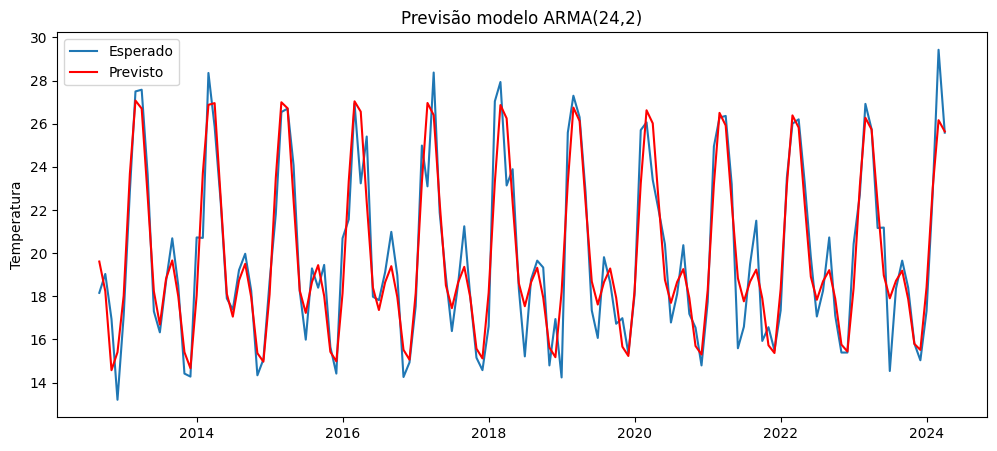


Métricas:

MAE: 1.0653989831778652
MSE: 1.9800654446528678


In [34]:
plot_prev(treino, teste, arma_mod_ot, 'ARMA(24,2)')

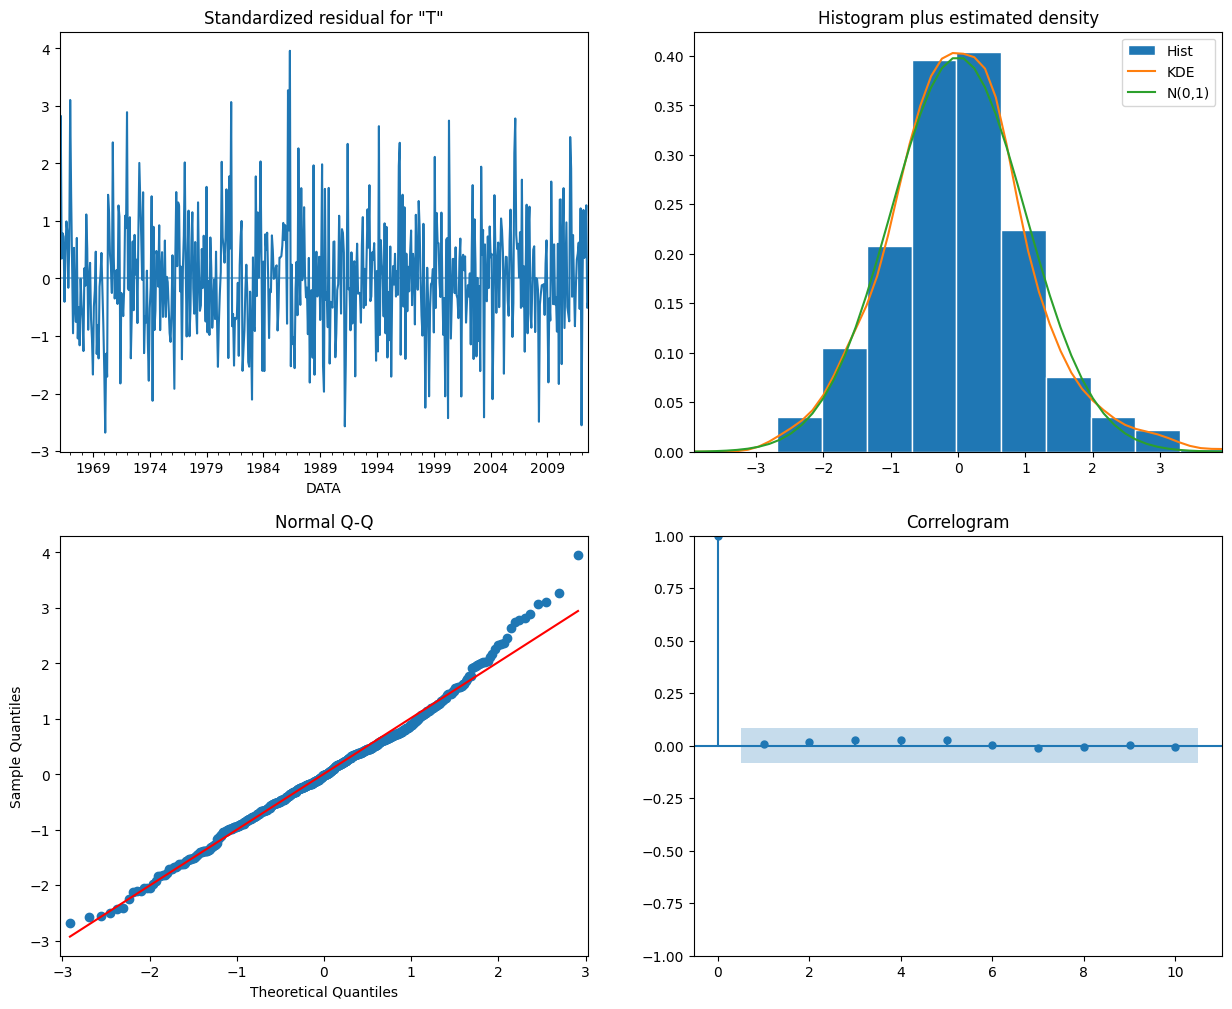

In [35]:
arma_mod_ot.plot_diagnostics(figsize=(15, 12))
plt.show()

# Fazenda 3

![Alt text: Imagem de uma fazenda com plantações de arroz](https://github.com/Mirlaa/s-ries-temporais-statsmodels/blob/main/imagens/Fazenda%203.png?raw=true)

In [36]:
df_f3 = pd.read_csv(dados_f3)
df_f3

,DATA,TEMP
0,1965-09-01,33.30
1,1965-10-01,32.88
2,1965-11-01,30.28
3,1965-12-01,30.42
4,1966-01-01,30.39
...,...,...
699,2023-12-01,31.72
700,2024-01-01,32.22
701,2024-02-01,32.29
702,2024-03-01,29.60


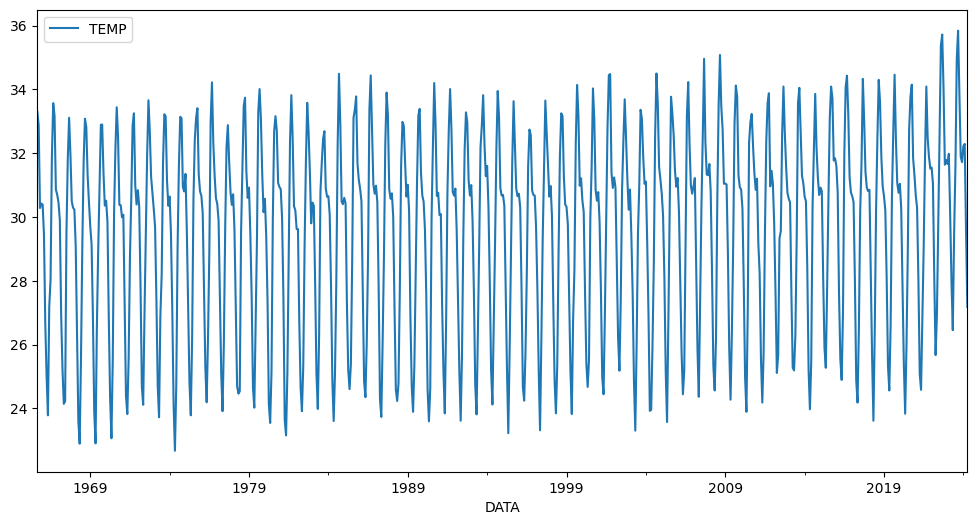

In [37]:
df_f3['DATA'] = pd.to_datetime(df_f3['DATA'], format='%Y-%m-%d')
df_f3.set_index(['DATA'], inplace=True, drop=True)
fig = df_f3.plot(figsize=(12, 6))

In [38]:
estac(df_f3)

Valor-p do Teste estatistico ADF :0.0669
Não rejeitar a hipótese nula. A série não é estacionária

Valor-p do Teste estatistico KPSS :0.0100
Rejeitar a hipótese nula. A série não é estacionária


In [39]:
df_f3.diff(1)

,TEMP
DATA,
1965-09-01,NaN
1965-10-01,-0.42
1965-11-01,-2.60
1965-12-01,0.14
1966-01-01,-0.03
...,...
2023-12-01,-0.16
2024-01-01,0.50
2024-02-01,0.07


In [40]:
estac(df_f3.diff().iloc[1:])

Valor-p do Teste estatistico ADF :0.0000
Rejeitar a hipótese nula. A série é estacionária

Valor-p do Teste estatistico KPSS :0.1000
Não rejeitar a hipótese nula. A série é estacionária


## Modelo Integrado Autorregressivo de Média Móveis (ARIMA)

In [41]:
divisao = int(len(df_f3) * 0.8)

treino = df_f3.iloc[:divisao].asfreq('MS')
teste = df_f3.iloc[divisao:].asfreq('MS')

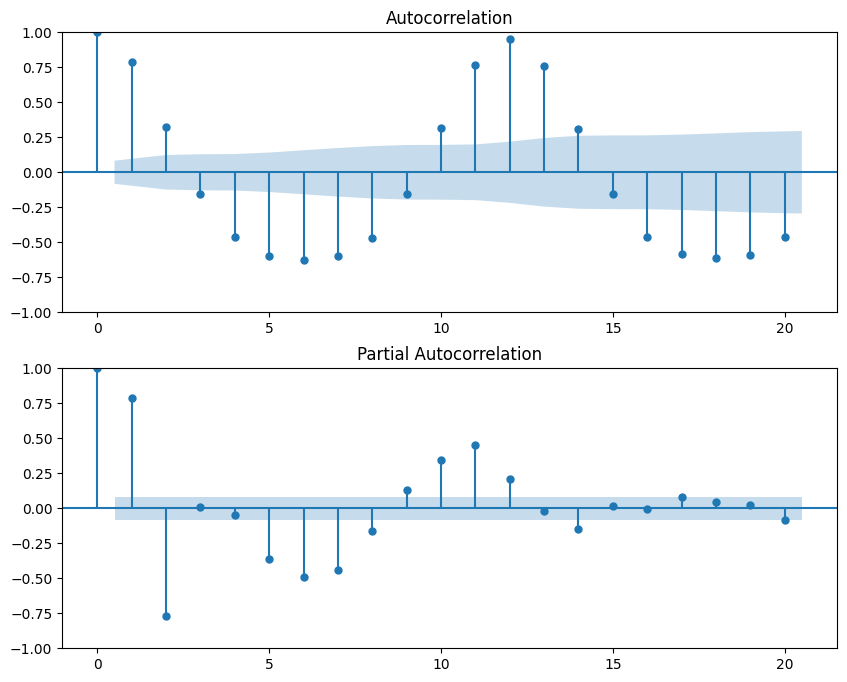

In [42]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=20, ax=ax2)

O modelo ARIMA combina três componentes principais: autorregressivo (AR), diferenciado (I de Integrated, ou integrado) e de média móvel (MA), o que o torna capaz de modelar uma ampla variedade de dados temporais.

O modelo ARIMA é geralmente representado como ARIMA(p, d, q), onde:

- $(p)$ é o número de termos autoregressivos,
- $( d )$ é o número de diferenciações necessárias para tornar a série temporal estacionária,
- $( q )$ é o número de termos de média móvel.

A equação genérica do modelo ARIMA é:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - L)^d X_t = (1 + \sum_{j=1}^q \theta_j L^j) \epsilon_t$

In [43]:
arima_mod = ARIMA(treino, order = (14, 1, 2)).fit()
print(arima_mod.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(14, 1, 2)   Log Likelihood                -544.788
Date:                Wed, 17 Sep 2025   AIC                           1123.576
Time:                        22:33:30   BIC                           1197.212
Sample:                    09-01-1965   HQIC                          1152.325
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4135      0.323     -1.280      0.200      -1.046       0.219
ar.L2          0.1417      0.318      0.446      0.656      -0.481       0.764
ar.L3         -0.2485      0.255     -0.973      0.3

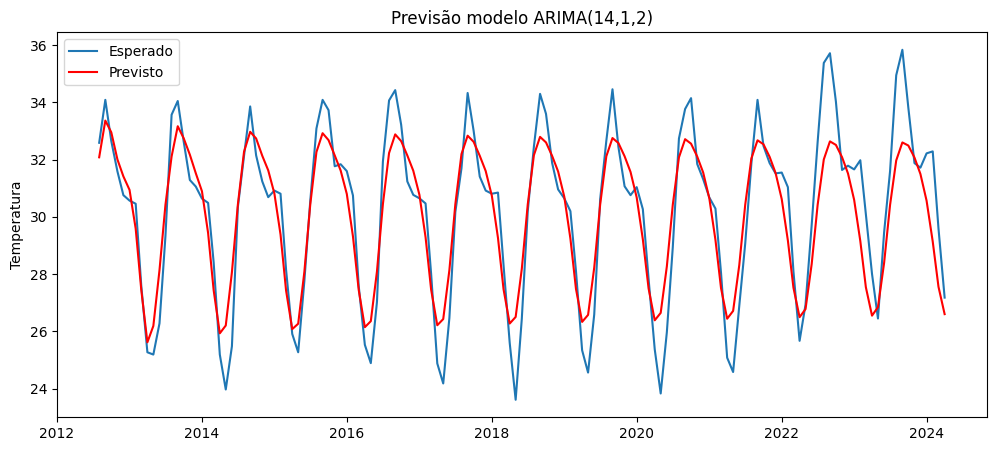


Métricas:

MAE: 1.0132040239737916
MSE: 1.6371233155685825


In [44]:
plot_prev(treino, teste, arima_mod, 'ARIMA(14,1,2)')

### Busca de parâmetros

In [45]:
aic_arima = grid_arima(14,25,1,3,1,treino)

In [46]:
aic_arima[1]

(24, 1, 2)

In [47]:
arima_mod_ot = ARIMA(treino, order = (24, 1, 2)).fit()
print(arima_mod_ot.summary())

                               SARIMAX Results                                
Dep. Variable:                   TEMP   No. Observations:                  563
Model:                ARIMA(24, 1, 2)   Log Likelihood                -504.928
Date:                Wed, 17 Sep 2025   AIC                           1063.856
Time:                        22:36:38   BIC                           1180.806
Sample:                    09-01-1965   HQIC                          1109.515
                         - 07-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4427      0.154     -2.874      0.004      -0.745      -0.141
ar.L2          0.1553      0.088      1.767      0.077      -0.017       0.328
ar.L3         -0.1382      0.073     -1.891      0.0

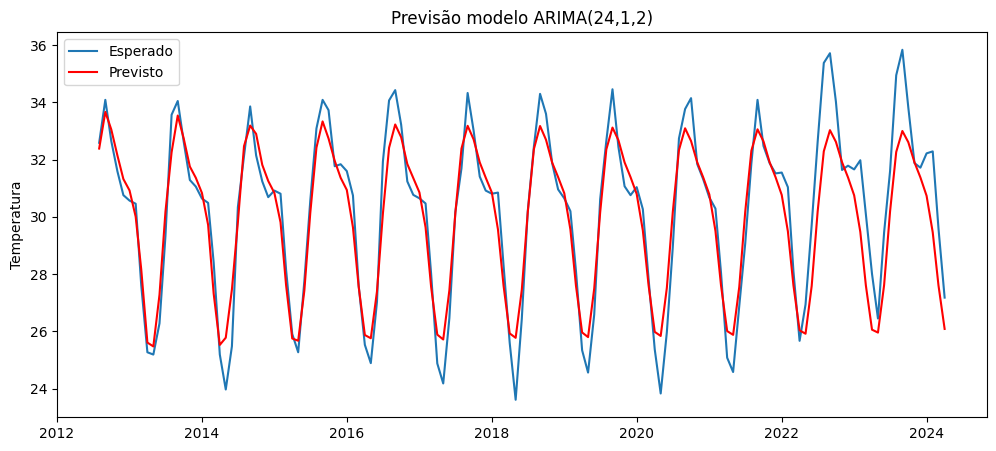


Métricas:

MAE: 0.8327305400563731
MSE: 1.1616412161205958


In [48]:
plot_prev(treino, teste, arima_mod_ot, 'ARIMA(24,1,2)')

### **A sazonalidade**

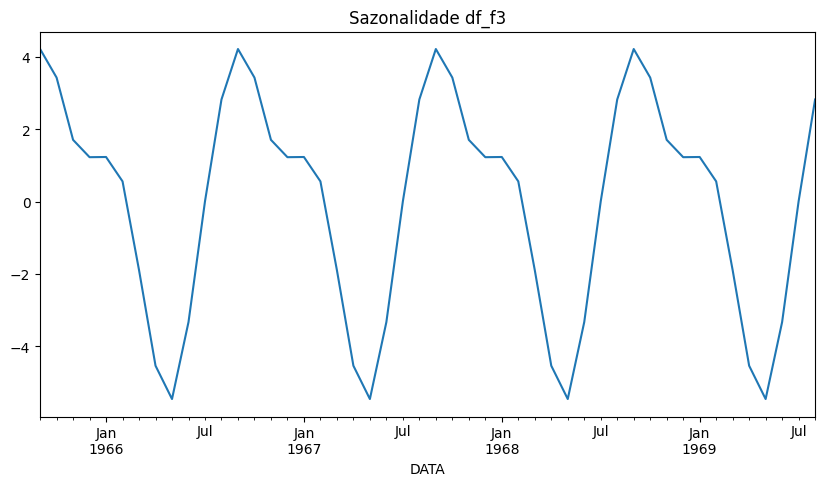

In [49]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposicao_df = seasonal_decompose(df_f3)

fig = plt.figure(figsize=(10,5))
decomposicao_df.seasonal.iloc[:48].plot(title='Sazonalidade df_f3')
plt.show()

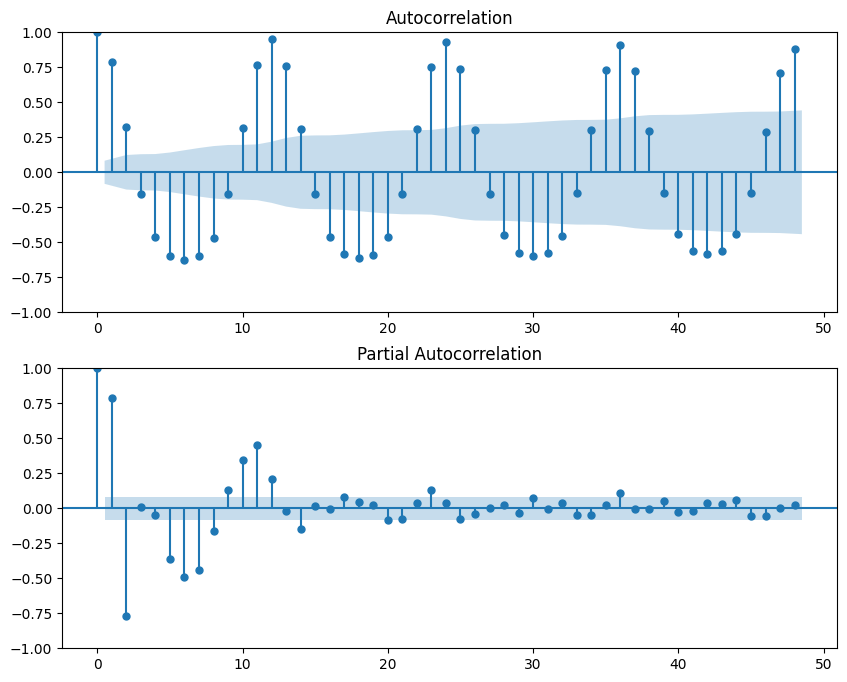

In [50]:
fig = plt.figure(figsize=(10, 8))
ax1 = fig.add_subplot(211)
fig = plot_acf(treino, lags=48, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(treino, lags=48, ax=ax2)

## Modelo Autorregressivo Sazonal de Média Móveis Integrado (SARIMA)

O modelo SARIMA é uma extensão do modelo ARIMA, projetado especificamente para modelar e prever séries temporais que exibem sazonalidade.

O modelo SARIMA pode ser descrito pela seguinte equação, que combina tanto os efeitos sazonais quanto os não sazonais:

$(1 - \sum_{i=1}^p \beta_i L^i)(1 - \sum_{i=1}^P B_i L^{is})(1 - L)^d(1 - L^s)^D X_t = (1 + \sum_{j=1}^q \theta_j L^j)(1 + \sum_{j=1}^Q \Theta_j L^{js}) \epsilon_t$

In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima_mod = SARIMAX(treino, order = (11,1,2), seasonal_order = (2,1,1,12)).fit()
print(sarima_mod.summary())

                                       SARIMAX Results                                       
Dep. Variable:                                  TEMP   No. Observations:                  563
Model:             SARIMAX(11, 1, 2)x(2, 1, [1], 12)   Log Likelihood                -456.394
Date:                               Wed, 17 Sep 2025   AIC                            946.787
Time:                                       22:37:20   BIC                           1020.056
Sample:                                   09-01-1965   HQIC                           975.419
                                        - 07-01-2012                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5650      0.147     -3.831      0.000      -0.854      -0.276
ar.L2      

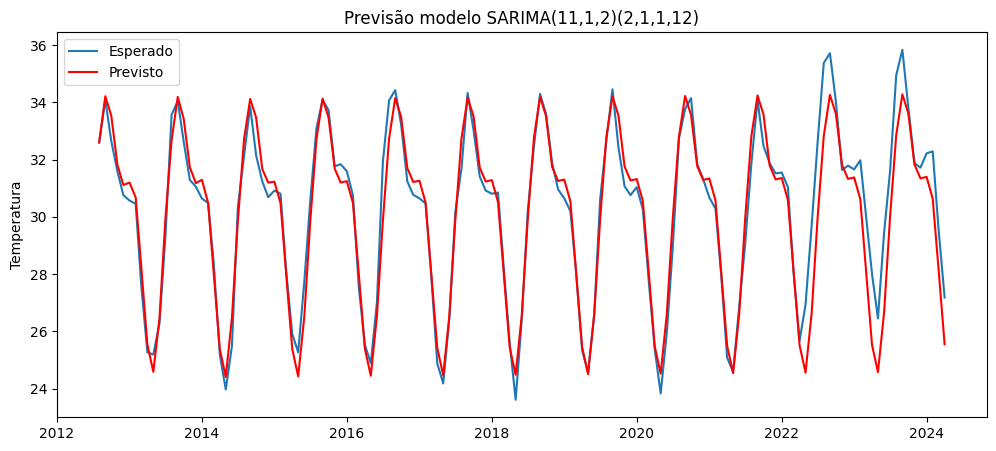


Métricas:

MAE: 0.5943406748554596
MSE: 0.7493423441372385


In [52]:
plot_prev(treino,teste,sarima_mod,'SARIMA(11,1,2)(2,1,1,12)')

# Previsões das Fazendas

Temos 3 modelos para 3 conjuntos de dados sobre as temperaturas das fazendas

* Fazenda 1 modelo $AR(34)$
* Fazenda 2 modelo $ARMA(24,2)$
* Fazenda 3 modelo $SARIMA(11, 1, 1)\times (2, 1, 1, 12)$

```Python
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()
```

In [53]:
mod_f1 = AutoReg(df_f1, 34, old_names=False).fit()
mod_f2 = ARIMA(df_f2, order=(24,0,2)).fit()
mod_f3 = SARIMAX(df_f3, order=(11, 1, 1), seasonal_order=(2, 1, 1, 12)).fit()

In [54]:
previsao_f1 = mod_f1.predict(len(df_f1), len(df_f1) + 35, dynamic=False)
previsao_f2 = mod_f2.predict(len(df_f2), len(df_f2) + 35, dynamic=False)
previsao_f3 = mod_f3.predict(len(df_f3), len(df_f3) + 35, dynamic=False)

In [55]:
previsao_f1

,0
2024-05-01,23.754813
2024-06-01,25.073979
2024-07-01,25.745189
2024-08-01,25.482945
2024-09-01,24.688088
2024-10-01,23.396004
2024-11-01,21.987786
2024-12-01,20.884098
2025-01-01,20.462515
2025-02-01,20.671650
